In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

## define function for I(Q)

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

In [3]:
def p_debye(Q,Rg):
    QRg = Q*Rg
    u = QRg**2
    p = 2*(np.exp(-u)+u-1)/(u**2)
    p[QRg==0] = 1
    return p

## evaluate probability density on 2D detector

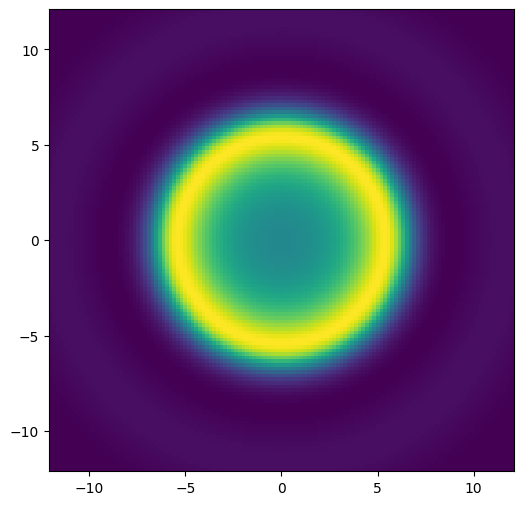

In [4]:
q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 0.01

p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3) + I_inc
# p_qxy =p_debye(q_rad, Rg=1)+ I_inc
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, p_qxy, cmap='viridis')

## random sampling the scattering intensity

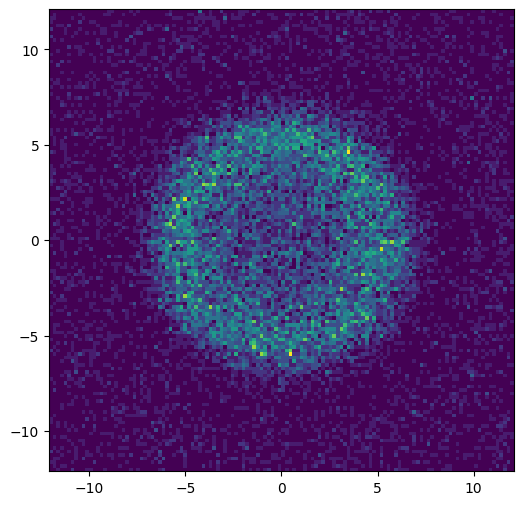

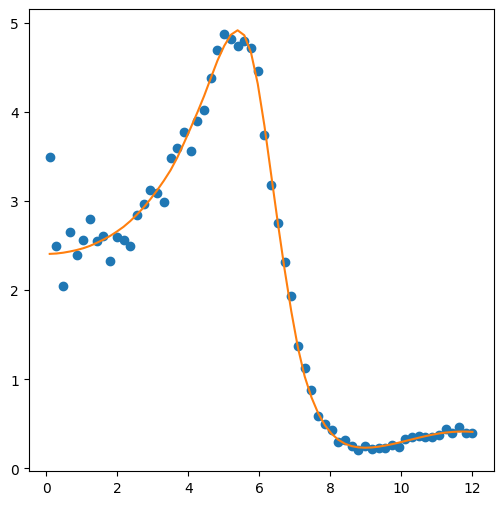

In [5]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]

n_sample = 20000  # specify the number of samples

n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

# Flatten the arrays
qx_flat = qx.flatten()
qy_flat = qy.flatten()
p_qxy_flat = p_qxy.flatten()

# Normalize the probability density
p_qxy_flat /= p_qxy_flat.sum()

# Randomly choose indices based on the probability density
indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

# Get the sampled qx and qy values
qx_samples = qx_flat[indices]
qy_samples = qy_flat[indices]

# evaluate the sampled point density in each grid

I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])


# evaluate the radial averaged density
q = q_grid[q_grid > 0]
I_q = np.zeros_like(q)
I_q_th = np.zeros_like(q)
for i in range(len(q)):
    mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
    I_q[i] = I_q_grid[mask].mean()
    I_q_th[i] = p_qxy[mask].mean()

# Plot the sampled point density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis')

# Plot the radial averaged density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(q, I_q, 'o')

ax.plot(q, I_q_th*n_sample, '-')

In [6]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy):
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    I_q_th = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

## handle with noise by GPR

-218.03489784653743


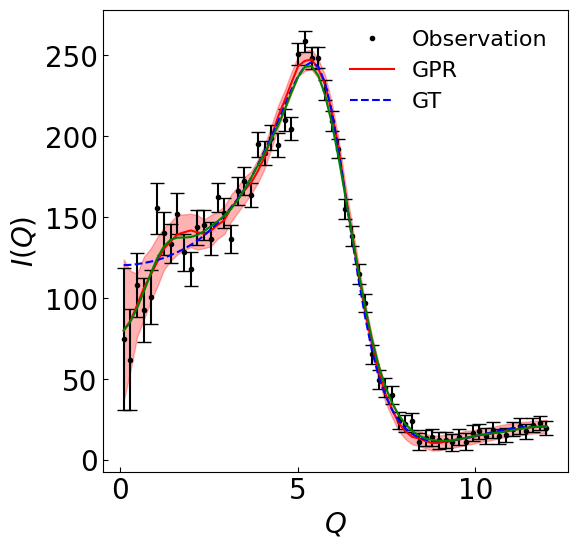

In [7]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, 2, mode='nearest')
    I_q_sv = savgol_filter(I_q, 15, 2, mode='nearest')
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0),2, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), 15, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR

## define kernel function
y_data = I_q_concat
y_bg = I_q_mean_sv
y_bg_concat = I_q_mean_gf_concat
y_gt = I_q_th
y = y_data-y_bg

# y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
# y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

# scale by a factor to check whether error estimation is correct
m_factor = 100
y_bg = y_bg*m_factor
y_bg_concat = y_bg_concat*m_factor
y_gt = y_gt*m_factor
y = y*m_factor
y_err = y_err*m_factor
y_data = y_data*m_factor
sig_var = np.mean(y**2)

q_x = q_concat
q_s = q

lmbda = 1
sigma = 10
def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
    if std_1 is None:
        std_1 = np.ones_like(q1)
    if std_2 is None:
        std_2 = np.ones_like(q2)
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
    return K

# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# evaluate the log likelihood
def f_log_likelihood(y, y_err, mu_s, std_s):
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    for z in np.linspace(-3, 3, 20):
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum(((y - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood

log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
print(log_likelihood)  

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + y_bg_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)

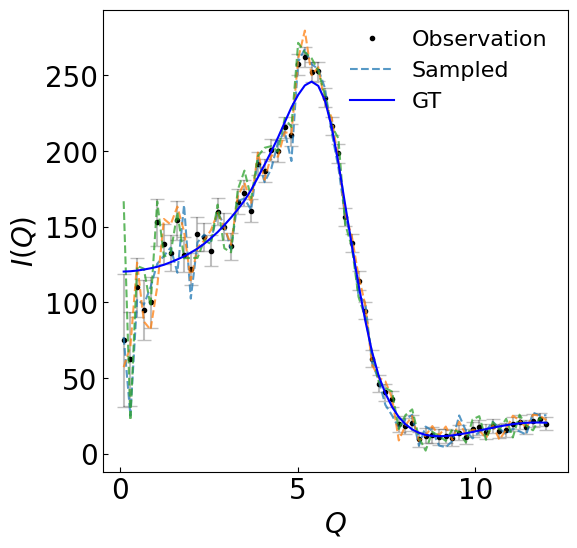

In [8]:
# sample from noisy data
n_curves = 3
I_q_samples = [np.random.normal(loc=y + y_bg, scale=y_err) for _ in range(n_curves)]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, '.k', label='Observation') 
ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.25)

for i, I_q_sample in enumerate(I_q_samples):
    label = ''
    if i == 0:
        label = 'Sampled'
    ax.plot(q_x, I_q_samples[i], '--', alpha=0.75, label=label)

ax.plot(q, y_gt , '-b', label='GT')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)

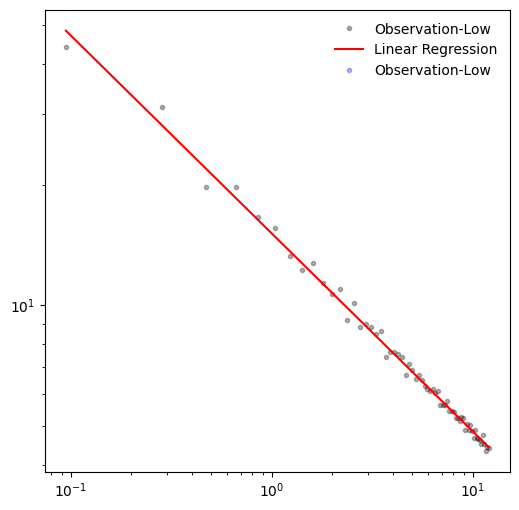

In [9]:
# Prepare the data for linear regression
log_qx = np.log(q_x)
log_y_err = np.log(y_err)

# Perform linear regression using numpy
A = np.vstack([log_qx, np.ones_like(log_qx)]).T
slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

# Identify data points that are too low below the regression line
threshold = 4  # Define a threshold for how many times below the regression line
i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y_err, '.k', label='Observation-Low', alpha=0.3) 
ax.plot(q_x, np.exp(intercept + slope * np.log(q_x)), '-r', label='Linear Regression')
ax.plot(q_x[i_low], y_err[i_low], '.b', label='Observation-Low', alpha=0.3) 
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')

# Find optimized noise scale

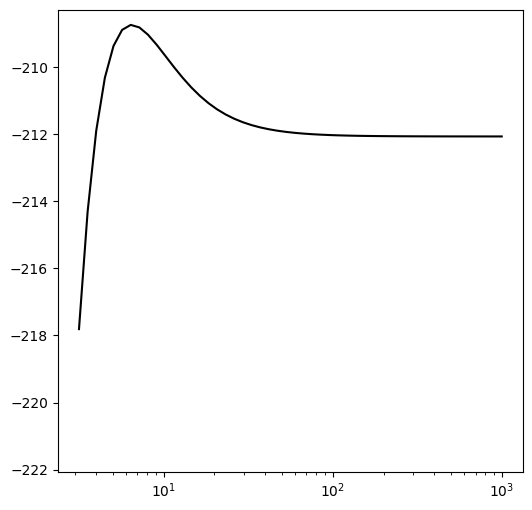

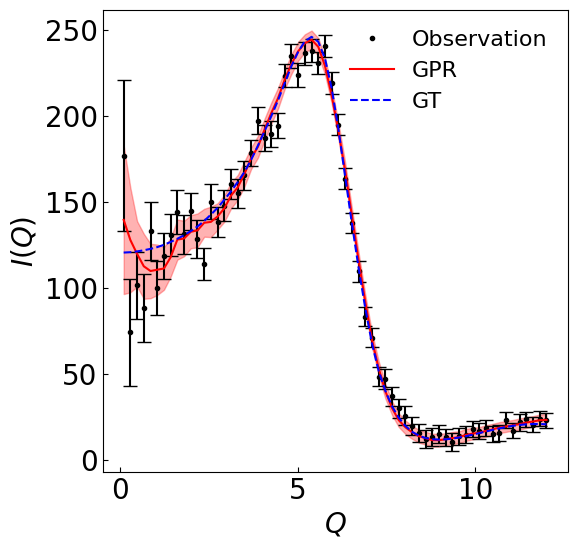

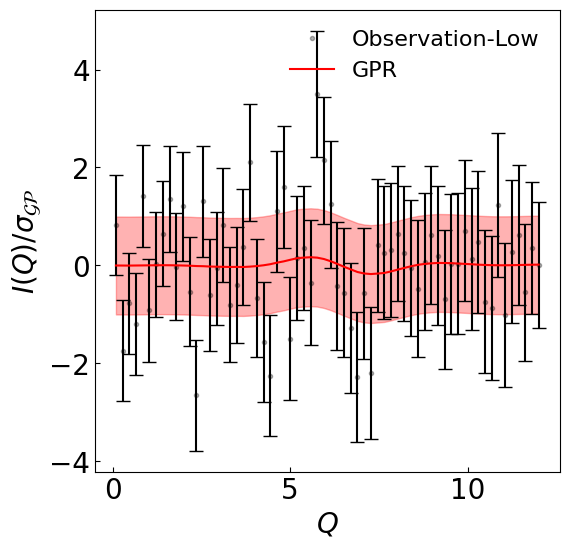

In [10]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_qxy) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_qxy, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, 2, mode='nearest')
    I_q_sv = savgol_filter(I_q, 15, 2, mode='nearest')
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0),2, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), 15, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(0.5, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = 1
    # sigma = 10

    ## define kernel function
    y_data = I_q_concat
    y_bg = I_q_mean_sv
    y_bg_concat = I_q_mean_gf_concat
    y_gt = I_q_th
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 100
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*y_err**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-10,None])

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg_concat, '.k', label='Observation') 
ax.errorbar(q_x, y + y_bg_concat, yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

## test on ILL data

In [11]:
filename_list = ['240253_low_stats_001.dat', '240253_med_stats_001.dat', '240254_high_stats_001.dat']
data_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/'+filename, skiprows=52)
    data_list.append(data)

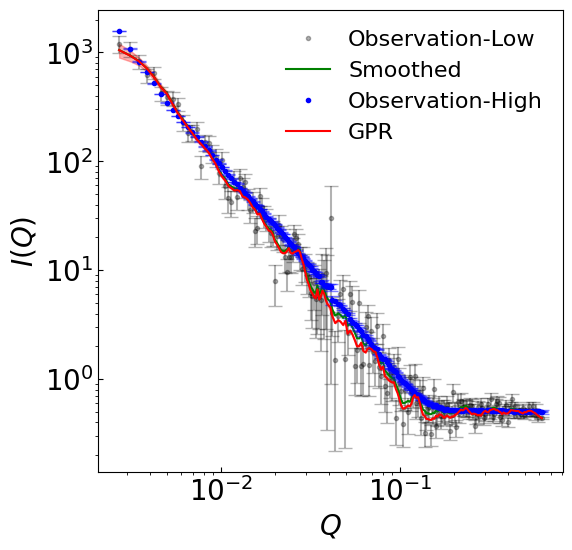

In [12]:
I_bg = 0.5
index_data = 0
data = data_list[index_data]
q_data = data[:, 0]
I_data = data[:, 1]+I_bg
I_err_data = data[:, 2]
I_data_gf = np.exp(gaussian_filter1d(np.log(I_data), 4, mode='nearest'))
I_data_sv = np.exp(savgol_filter((np.log(I_data)), 15, 2, mode='nearest'))

## "good data"
index_data = 2
data = data_list[index_data]
q_data_good = data[:, 0]
I_data_good = data[:, 1]+I_bg
I_err_data_good = data[:, 2]

## GPR

## define kernel function
y_bg = I_data_sv
y_data = I_data
y = y_data-y_bg

# y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
# y_err = np.sqrt(1/np.maximum(n_pixels_q_concat,np.ones_like(q)))
y_err = I_err_data#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

q_x = q_data
q_s = q_data

# exclude the data with unreasonably low error
# Prepare the data for linear regression
log_qx = np.log(q_x)
log_y_err = np.log(y_err)

# Perform linear regression using numpy
A = np.vstack([log_qx, np.ones_like(log_qx)]).T
slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

# Identify data points that are too low below the regression line
threshold = 4  # Define a threshold for how many times below the regression line
i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

# Remove the data points that errors are too low
q_x = np.delete(q_x, i_low)
q_s = np.delete(q_s, i_low)
y = np.delete(y, i_low)
y_err = np.delete(y_err, i_low)
y_bg = np.delete(y_bg, i_low)


lmbda = 1
sigma = 1
def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
    if std_1 is None:
        std_1 = np.ones_like(q1)
    if std_2 is None:
        std_2 = np.ones_like(q2)
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
    return K

f_q = lambda q: np.log(q)
# f_q = lambda q: q
f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(np.mean(y_err**2))**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)


fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, '.k', label='Observation-Low', alpha=0.3) 
ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_x, y_bg, '-g', label='Smoothed')
ax.plot(q_data_good, I_data_good, '.b', label='Observation-High') 
ax.errorbar(q_data_good, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5, alpha=0.5)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)


ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.legend(frameon=False, fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

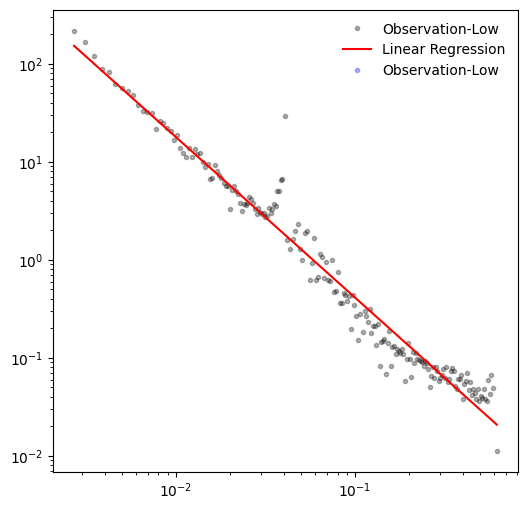

In [13]:
# Prepare the data for linear regression
log_qx = np.log(q_x)
log_y_err = np.log(y_err)

# Perform linear regression using numpy
A = np.vstack([log_qx, np.ones_like(log_qx)]).T
slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

# Identify data points that are too low below the regression line
threshold = 4  # Define a threshold for how many times below the regression line
i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y_err, '.k', label='Observation-Low', alpha=0.3) 
ax.plot(q_x, np.exp(intercept + slope * np.log(q_x)), '-r', label='Linear Regression')
ax.plot(q_x[i_low], y_err[i_low], '.b', label='Observation-Low', alpha=0.3) 
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')

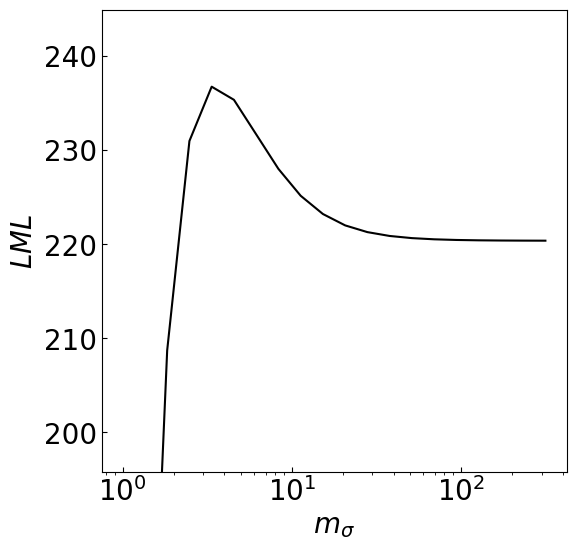

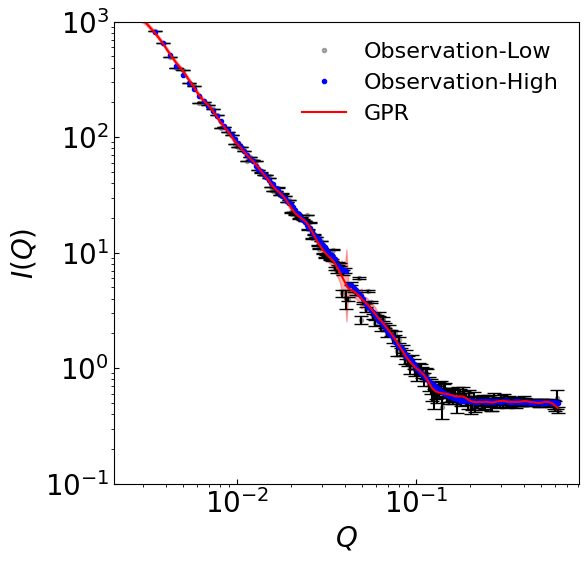

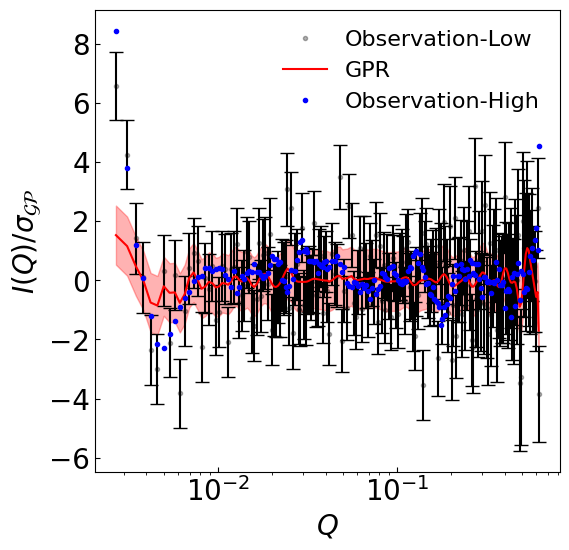

In [16]:
I_bg = 0.5
sv_size = 15
index_data = 1
data = data_list[index_data]
q_data = data[:, 0]
I_data = data[:, 1]+I_bg
I_err_data = data[:, 2]
I_data_gf = np.exp(gaussian_filter1d(np.log(I_data), 3, mode='nearest'))
I_data_sv = np.exp(savgol_filter((np.log(I_data)), sv_size, 2, mode='nearest'))
I_data_md = median_filter(I_data, size=sv_size)

## "good data"
index_data = 2
data = data_list[index_data]
q_data_good = data[:, 0]
I_data_good = data[:, 1]+I_bg
I_err_data_good = data[:, 2]

## GPR
sigma_list = np.logspace(0, 2.5, 20)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = 0.05
    # sigma = 10

    # define observation
    y_data = np.log(I_data)
    y_bg = np.log(I_data_gf)
    y_bg_concat = y_bg
    y_gt = np.log(I_data_good)
    y = y_data-y_bg
    y_err = I_err_data/I_data
    
    sig_var = np.mean(y**2)    

    q_x = q_data
    q_s = q_data
    
    # exclude the data with unreasonably low error
    # Prepare the data for linear regression
    log_qx = np.log(q_x)
    log_y_err = np.log(y_err)

    # Perform linear regression using numpy
    A = np.vstack([log_qx, np.ones_like(log_qx)]).T
    slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

    # Identify data points that are too low below the regression line
    threshold = 4  # Define a threshold for how many times below the regression line
    i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

    # Remove the data points that errors are too low
    q_x = np.delete(q_x, i_low)
    q_s = np.delete(q_s, i_low)
    y = np.delete(y, i_low)
    y_err = np.delete(y_err, i_low)
    y_bg = np.delete(y_bg, i_low)

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*y_err**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])

ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'$LML$', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, np.exp(y + y_bg), '.k', label='Observation-Low', alpha=0.3) 
ax.errorbar(q_x, np.exp(y + y_bg), yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_data_good, I_data_good, '.b', label='Observation-High') 

ax.plot(q_s, np.exp(mu_s + y_bg), '-r', label='GPR')
ax.fill_between(q_s, np.exp(mu_s - std_s + y_bg), np.exp(mu_s + std_s + y_bg), color='r', alpha=0.3)

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim([1e-1, 1e3])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# interpolate the uncertainty to the good data
f_interp_std = interp1d(q_x, std_s, bounds_error=False, fill_value='extrapolate')
f_interp_bg = interp1d(q_x, y_bg, bounds_error=False, fill_value='extrapolate')
std_s_good = f_interp_std(q_data_good)
bg_good = f_interp_bg(q_data_good)
ax.plot(q_data_good, (np.log(I_data_good)-bg_good)/std_s_good, '.b', label='Observation-High') 

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)
ax.set_xscale('log')
# ax.set_yscale('log')

In [17]:
filename_list = ['026.dat', '036.dat', 'SEC1_26-48.dat']
data_list = []

for i_file, filename in enumerate(filename_list):
    data = np.loadtxt('./data/ILL_bio/'+filename, skiprows=52)
    data_list.append(data)

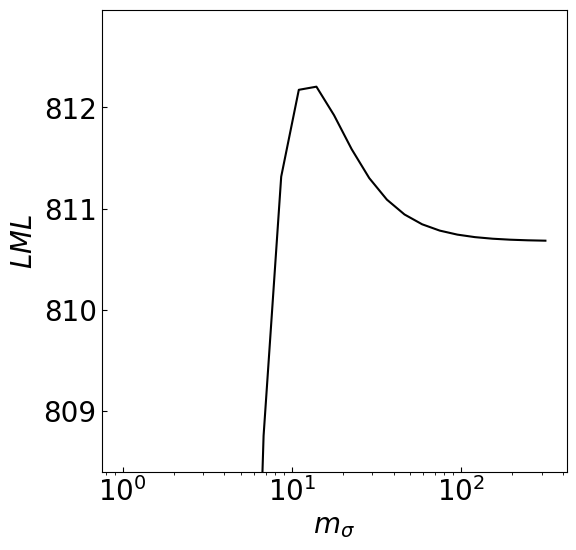

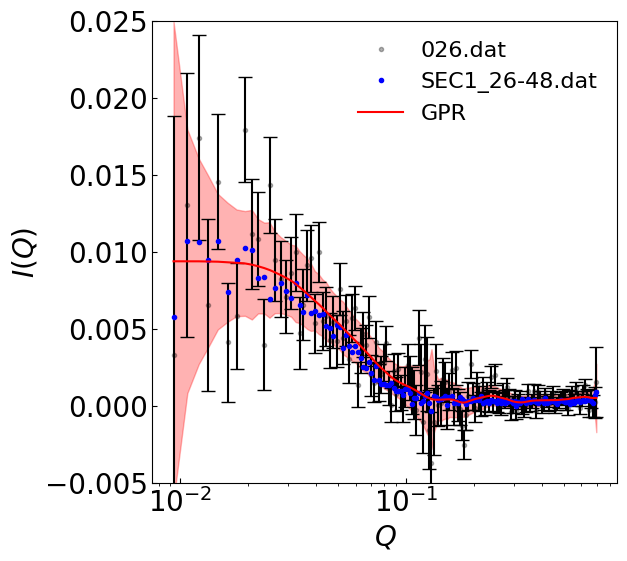

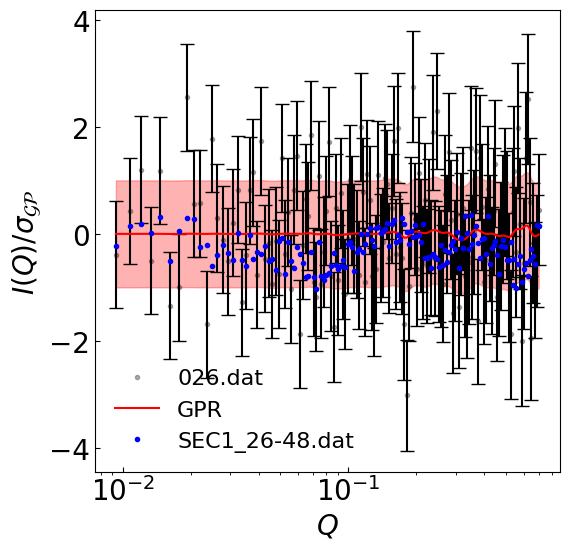

In [57]:
I_bg = 1e-2
sv_size = 15
index_data = 0
data = data_list[index_data]
q_data = data[:, 0]
I_data = data[:, 1]
I_err_data = data[:, 2]
I_data_gf = np.exp(gaussian_filter1d(np.log(I_data+I_bg), 6, mode='reflect'))-I_bg
I_data_sv = np.exp(savgol_filter((np.log(I_data+I_bg)), sv_size, 2, mode='nearest'))-I_bg
# I_data_gf = (gaussian_filter1d((I_data), 5, mode='nearest'))
# I_data_sv = (savgol_filter(((I_data)), sv_size, 2, mode='nearest'))
I_data_md = median_filter(I_data+I_bg, size=sv_size)-I_bg

## "good data"
index_data_good = 2
data = data_list[index_data_good]
q_data_good = data[:, 0]
I_data_good = data[:, 1]
I_err_data_good = data[:, 2]

## GPR
sigma_list = np.logspace(0, 2.5, 25)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = 0.05
    # sigma = 10

    # define observation
    y_data = I_data
    y_bg = I_data_gf
    y_bg_concat = y_bg
    y_gt = I_data_good
    y = y_data-y_bg
    y_err = I_err_data
    
    sig_var = np.mean(y**2)    

    q_x = q_data
    q_s = q_data
    
    # exclude the data with unreasonably low error
    # Prepare the data for linear regression
    log_qx = np.log(q_x)
    log_y_err = np.log(y_err)

    # Perform linear regression using numpy
    A = np.vstack([log_qx, np.ones_like(log_qx)]).T
    slope, intercept = np.linalg.lstsq(A, log_y_err, rcond=None)[0]

    # Identify data points that are too low below the regression line
    threshold = 4  # Define a threshold for how many times below the regression line
    i_low = np.where(log_y_err < intercept + slope * log_qx - np.log(threshold))[0]

    # Remove the data points that errors are too low
    q_x = np.delete(q_x, i_low)
    q_s = np.delete(q_s, i_low)
    y = np.delete(y, i_low)
    y_err = np.delete(y_err, i_low)
    y_bg = np.delete(y_bg, i_low)

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*y_err**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])

ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'$LML$', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, (y + y_bg), '.k', label=filename_list[index_data], alpha=0.3) 
ax.errorbar(q_x, (y + y_bg), yerr=y_err, fmt='none', ecolor='k', capsize=5)
ax.plot(q_data_good, I_data_good, '.b', label=filename_list[index_data_good]) 

ax.plot(q_s, (mu_s + y_bg), '-r', label='GPR')
ax.fill_between(q_s, (mu_s - std_s + y_bg), (mu_s + std_s + y_bg), color='r', alpha=0.3)

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-1, 1e3])
ax.set_ylim([-0.005, 0.025])

ax.legend(frameon=False, fontsize=16)
ax.set_xscale('log')
# ax.set_yscale('log')

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y/std_s, '.k', label=filename_list[index_data], alpha=0.3) 
ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# interpolate the uncertainty to the good data
f_interp_std = interp1d(q_x, std_s, bounds_error=False, fill_value='extrapolate')
f_interp_bg = interp1d(q_x, y_bg, bounds_error=False, fill_value='extrapolate')
std_s_good = f_interp_std(q_data_good)
bg_good = f_interp_bg(q_data_good)
ax.plot(q_data_good, ((I_data_good)-bg_good)/std_s_good, '.b', label=filename_list[index_data_good]) 

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=16)
ax.set_xscale('log')
# ax.set_yscale('log')